In [1]:
# Simpler env version

## Task

A color sample folder is composed of one or more sheets where color samples corresponding to one collection are glued (fabric samples, mosaic samples, wood samples, etc.).

The samples are typically glued to the sheets using double-sided tape by paper manufacturing workers: this is a **repetitive job, that requires concentration both to select the right sample and to correctly position it**.

For this reason, we developed a **collaborative framework** where cobot and human operator collaborate together in the realization of single parts of a mosaic tiles color sample folder.

In particular, **the cobot can intervene when the operator’s productivity and concentration decrease**, carrying out tasks initially assigned to the operator.

### Setup

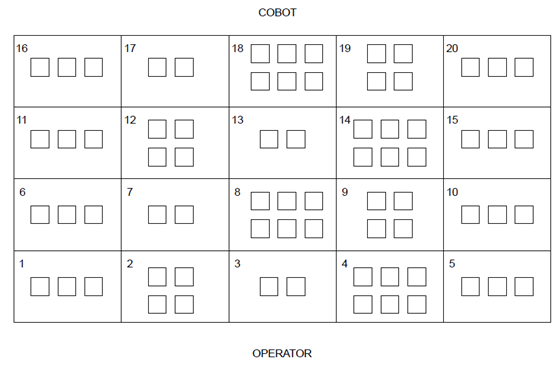

*   Activities organized in cycles
*   Each cycle is composed of **20 tasks**
*   Each task consists of assembling a sheet (group of mosaic tiles). For instance: task 1 &rarr; 3 mosaic tiles,
task 2 &rarr; 4 mosaic tiles
*   Tasks are assigned to the robot and the operator
*   The **robot can not** perform tasks **1, 2, 3, 4, 5, 6, 10** (outside the reachable
space)
*   The **operator can not** perform tasks **11, 15, 16, 17, 18, 19, 20**



## MDP

In [7]:
import numpy as np
np.random.seed(1) 

In [16]:
class CobotEnv:
    """
    The Cobot environment
    """

    def __init__(self, n_operators: int, robot_execution_time: list, id_operator: int, mu_operators: tuple, std: float = 0.04) -> None:
        """
        Initializes an Cobot environment

        Parameters
        ----------
        n_operators : int
            Number of human operators
        robot_execution_time : list
            List containing the robot task processing time
        id_operator : int
            Id of the operator
        mu_operators : tuple
            Tuple of shape (n_operators x n_tasks) containing the mean values of the normal distribution for each task for each human operator
        std : float
            Standard deviation of the normal distribution used to sample operators' processing time (default 0.04)
        """
        self.std = std
        self.robot_execution_time = np.array(robot_execution_time) # robot tasks execution time
        self.n_operators = n_operators
        self.mu_operators = mu_operators
        assert len(self.mu_operators) == self.n_operators, "Invalid Input!" # 'mu_operators' must have the same length as n_operators

        # Ids of the tasks performable by robot and human operators
        self.robot_task_id = np.array((7,8,9,11,12,13,14,15,16,17,18,19,20))
        self.operator_task_id = np.array((1,2,3,4,5,6,7,8,9,10,12,13,14))

        #set the initial state and sample new processing time of human operators
        self.reset(id_operator)


    def reset(self, id_operator: int) -> tuple[tuple, np.ndarray]:
        """
        Reset the environment to the initial state and re-sample new processing time of the human operators and returns the initial observation

        Parameters
        ----------
        id_operator : int
            Id of the operator

        Returns
        -------
        tuple, np.ndarray
            Initial state of the environment and sampled execution time of the human operators
        """

        self.operators_sampled_time = self.sample_process_time() #operators processing time: (n_operators x n_tasks)
        self.id_operator = id_operator
        
        # State
        self.robot_done = np.zeros(len(self.robot_task_id), dtype='int') # 0 = not done, 1 = done
        self.robot_scheduled = 0 # id of the task the robot has scheduled, 0 otherwise
        self.operator_done = np.zeros(len(self.operator_task_id), dtype='int') # 0 = not done, 1 = done
        self.operator_scheduled = 0 # id of the task the operator has scheduled, 0 otherwise
        self.operator_execution_time = np.copy(self.operators_sampled_time[self.id_operator]) # operators tasks execution time

        return self.get_state(), self.operators_sampled_time


    def step(self, action: int, new_id_operator: int = None) -> tuple[tuple, float, bool]:
        """
        Simulates scheduling action and calculates rewards

        Parameters
        ----------
        action : int
            Id of the next scheduled tasks
        new_id_operator : Optional[int]
            Id of the new operator, None otherwise
        
        Returns
        -------
        tuple, float, bool
            Current state of the environment, reward, whether the episode is over or not
        """

        assert (action >= min(min(robot_task_id),min(operator_task_id))) and (action <= max(max(robot_task_id),max(operator_task_id))), "Invalid input!"
        
        # change operator and update execution time in state
        if new_id_operator is not None:
            
            self.set_operator(new_id_operator)
        
        #######################
        ### Task assignment ###
        #######################
        
        # both robot and operator have no task scheduled
        # REMEMBER: in this case both robot and operator always have at least one schedulable task, and there are at least 2 tasks left
        if self.operator_scheduled == 0 and self.robot_scheduled == 0:
            
            # assign to robot
            self.robot_scheduled = action
            
            if self.check_and_finish():
                return self.get_state(), -self.get_total_time(), True

            # end step
            return self.get_state(), 0, False

        # robot has no task scheduled
        elif self.robot_scheduled == 0:

            # update state - robot
            self.robot_scheduled = action

        # operator has no task scheduled
        else:

            # update state - operator
            self.operator_scheduled = action

        
        ########################
        ### Task fulfillment ###
        ########################
        
        # accomplished robot tasks time + robot scheduled task ex. time
        robot_time = np.sum(self.robot_done*self.robot_execution_time) + self.robot_execution_time[np.where(self.robot_task_id==self.robot_scheduled)[0][0]]
        # accomplished operator tasks time + operator scheduled task ex. time
        operator_time = np.sum(self.operator_done*self.operator_execution_time) + self.operator_execution_time[np.where(self.operator_task_id==self.operator_scheduled)[0][0]]

        # robot finishes first
        if robot_time < operator_time:
            
            # update state - robot
            self.robot_done[np.where(self.robot_task_id==self.robot_scheduled)[0][0]] = 1 # set the scheduled task as "done"
            self.robot_scheduled = 0
                
            if self.check_and_finish():
                return self.get_state(), -self.get_total_time(), True

        # operator finishes first
        elif robot_time > operator_time:

            # update state - operator
            self.operator_done[np.where(self.operator_task_id==self.operator_scheduled)[0][0]] = 1 # set the scheduled task as "done"
            self.operator_scheduled = 0
            
            if self.check_and_finish():
                return self.get_state(), -self.get_total_time(), True
            
        # robot and operator finish simultaneously
        else:

            # update state
            self.robot_done[np.where(self.robot_task_id==self.robot_scheduled)[0][0]] = 1 # set the scheduled task as "done"
            self.robot_scheduled = 0
            self.operator_done[np.where(self.operator_task_id==self.operator_scheduled)[0][0]] = 1 # set the scheduled task as "done"
            self.operator_scheduled = 0

            if self.check_and_finish():
                self.get_state(), -self.get_total_time(), True

        # end of step
        return self.get_state(), 0, False


    def check_and_finish() -> bool:
        """
        Returns
        -------
        bool
            True if the episode is over, False otherwise
        """

        if self.robot_scheduled == 0 and self.operator_scheduled == 0:
            
            # Check whether robot and operator have no schedulable tasks in common (come quando sono finiti i task: is_over() = True) or one of them has no longer schedulable tasks
            
            robot_task_done = self.robot_task_id * self.robot_done
            operator_task_done = self.operator_task_id * self.operator_done
            task_scheduled_so_far = np.concatenate((robot_task_done[robot_task_done!=0], operator_task_done[operator_task_done!=0]))
            
            robot_task_to_be_done = np.setdiff1d(self.robot_task_id, task_scheduled_so_far)
            operator_task_to_be_done = np.setdiff1d(self.operator_task_id, task_scheduled_so_far)

            # if robot and operator have no schedulable tasks in common
            if np.intersect1d(robot_task_to_be_done, operator_task_to_be_done).size == 0:
                
                self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1
                self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
            
                return True # end of episode

            #if the there's a common task, but it's the last one left
            elif task_scheduled_so_far.size == 19:

                # if robot completes the last task faster than (or equal to) operator
                if self.robot_execution_time[np.where(self.robot_task_id==self.robot_task_to_be_done[0])[0][0]] <= \
                    self.operator_execution_time[np.where(self.operator_task_id==self.operator_task_to_be_done[0])[0][0]]:
                    
                    # robot finisce l'ultimo task, poi finisci episodio    
                    self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1
                    
                else:
                    
                    # operator finisce l'ultimo task, poi finisci episodio    
                    self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
                    
                # end of episode
                return True
                
        elif self.robot_scheduled == 0:

            # Check whether robot and operator have no schedulable tasks in common, or robot  has no longer a schedulable task
            
            robot_task_done = self.robot_task_id * self.robot_done
            operator_task_done = self.operator_task_id * self.operator_done
            task_scheduled_so_far = np.concatenate((robot_task_done[robot_task_done!=0], operator_task_done[operator_task_done!=0], [self.operator_scheduled]))
            
            robot_task_to_be_done = np.setdiff1d(self.robot_task_id, task_scheduled_so_far)
            operator_task_to_be_done = np.setdiff1d(self.operator_task_id, task_scheduled_so_far)

            # if robot and operator have no schedulable tasks in common
            if np.intersect1d(robot_task_to_be_done, operator_task_to_be_done).size == 0:

                # execute operator scheduled task
                self.operator_done[np.where(self.operator_task_id==self.operator_scheduled)[0][0]] = 1
                self.operator_scheduled = 0
            
                self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1
                self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
            
                return True # end of episode

            #if the there's a common task, but robot has only that task left, and it's waiting for it
            elif robot_task_to_be_done.size == 1:
            
                # execute operator scheduled task
                self.operator_done[np.where(self.operator_task_id==self.operator_scheduled)[0][0]] = 1
                self.operator_scheduled = 0
               
                self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1           
                self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
                self.operator_done[np.where(np.isin(self.operator_task_id, robot_task_to_be_done))[0]] = 0 # l'ultimo task rimasto al robot, che è un task in comune, non deve essere segnato fatto anche da operator  

                # end of episode
                return True

        else: #self.operator_scheduled == 0
            # Check whether robot and operator have no schedulable tasks in common
            
            robot_task_done = self.robot_task_id * self.robot_done
            operator_task_done = self.operator_task_id * self.operator_done
            task_scheduled_so_far = np.concatenate((robot_task_done[robot_task_done!=0], operator_task_done[operator_task_done!=0], [self.robot_scheduled]))
            
            robot_task_to_be_done = np.setdiff1d(self.robot_task_id, task_scheduled_so_far)
            operator_task_to_be_done = np.setdiff1d(self.operator_task_id, task_scheduled_so_far)

            # if robot and operator have no schedulable tasks in common
            if np.intersect1d(robot_task_to_be_done, operator_task_to_be_done).size == 0:

                # execute robot scheduled task
                self.robot_done[np.where(self.robot_task_id==self.robot_scheduled)[0][0]] = 1
                self.robot_scheduled = 0
            
                self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1
                self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
            
                return True # end of episode

            #if the there's a common task, but operator has only that task left, and it's waiting for it
            elif operator_task_to_be_done.size == 1:
            
                # execute robot scheduled task
                self.robot_done[np.where(self.robot_task_id==self.robot_scheduled)[0][0]] = 1
                self.robot_scheduled = 0

                self.robot_done[np.where(np.isin(self.robot_task_id, robot_task_to_be_done))[0]] = 1
                self.robot_done[np.where(np.isin(self.robot_task_id, operator_task_to_be_done))[0]] = 0
                self.operator_done[np.where(np.isin(self.operator_task_id, operator_task_to_be_done))[0]] = 1
            
                # end of episode
                return True
            
            
    def sample_process_time(self) -> np.ndarray:
        """
        Samples processing time for each task for each operator

        Returns
        -------
        np.ndarray
            Array of shape (n_operators x n_tasks) containing the processing time for each task for each operator
        """
        
        return np.array([np.around(np.random.normal(loc=self.mu_operators[i], scale=self.std), decimals=3) for i in range(self.n_operators)])


    def set_operator(self, new_id_operator: int) -> None:
        """
        Set new operator and change operator execution time in state

        Parameters
        ----------
        id_operator : int
            Id of the new operator
        """
        
        assert new_id_operator < self.n_operators, "Invalid Input!"

        # set new id operator
        self.id_operator = new_id_operator
        
        # only update the time of those tasks that are not done by robot or operator yet 
        self.operator_execution_time[np.intersect1d(np.where(self.operator_done==0)[0], np.where(self.robot_done==0)[0])] = \
                self.operators_sampled_time[self.id_operator][np.intersect1d(np.where(self.operator_done==0)[0], np.where(self.robot_done==0)[0])]


    def is_over(self) -> bool:
        """
        Check whether the episode is over

        Returns
        -------
        bool
            True whether the episode is over, False otherwise
        """
        
        return np.sum(self.robot_done) + np.sum(self.operator_done) == 20.0 # sum of number tasks done by robot and tasks done by operators must be 20 at the end of an episode

    
    def get_total_time(self) -> float:
        """
        Return the total elapsed time of the episode

        Returns
        -------
        float
            Episode elapsed time
        """
        
        # robot total time
        r = np.sum(self.robot_done*self.robot_execution_time)
        # operator total time
        t = np.sum(self.operator_done*self.operator_execution_time)
        
        return max(r,t)


    def get_state(self) -> tuple:
        """
        Return the current state of the environment

        Returns
        -------
        np.ndarray
            Current state
        """
        
        return self.robot_done, self.robot_scheduled, self.robot_execution_time, self.operator_done, self.operator_scheduled, self.operator_execution_time

## TEST

In [3]:
robot_process_time = (0.372,1.1,0.685,0.47,0.489,0.271,1.1,0.62,0.333,0.23,0.878,0.809,0.711) # taken from data, constant
slow_operator_process_time = (0.5,0.667,0.333,1,0.5,0.5,0.333,1,0.667,0.5,0.667,0.5,1) # taken from data, used as mean values
t=0.8
expert_operator_process_time = tuple([round(mu*t, 3) for mu in slow_operator_process_time]) # 80% of slow operator, used as mean values
mu_operators = (slow_operator_process_time,expert_operator_process_time)

print("Robot process time for each possible task it can perform: ",robot_process_time,'\n')
print("Slow operator process time for each possible task it can perform: ",slow_operator_process_time,'\n')
print("Expert operator process time for each possible task it can perform: ",expert_operator_process_time,'\n')

Robot process time for each possible task it can perform:  (0.372, 1.1, 0.685, 0.47, 0.489, 0.271, 1.1, 0.62, 0.333, 0.23, 0.878, 0.809, 0.711) 

Slow operator process time for each possible task it can perform:  (0.5, 0.667, 0.333, 1, 0.5, 0.5, 0.333, 1, 0.667, 0.5, 0.667, 0.5, 1) 

Expert operator process time for each possible task it can perform:  (0.4, 0.534, 0.266, 0.8, 0.4, 0.4, 0.266, 0.8, 0.534, 0.4, 0.534, 0.4, 0.8) 



In [4]:
env = CobotEnv(2, robot_process_time, 0, mu_operators, 0.04)

In [5]:
i = 0
print("Step numero ", i)
print("- Stato: \n",env.state)
print("- Total time: ",env.get_total_time())
print("- Is over? ", env.is_over())

Step numero  0
- Stato: 
 [[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.565 0.643 0.312 0.957 0.535 0.408 0.403 0.97  0.68  0.49  0.725 0.418
  0.987]]
- Total time:  0.0
- Is over?  False


In [6]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[1,0,2,8,3,0,4,9,5,10,6,11,7],[3,5,6,7,8,9,0,2,0,4,0,1,0]],1)
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  1
- Stato: 
 [[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.   ]
 [ 0.     0.     1.     7.     2.     0.     3.     8.     4.     9.
   5.    10.     6.   ]
 [ 0.372  1.1    0.685  0.47   0.489  0.271  1.1    0.62   0.333  0.23
   0.878  0.809  0.711]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.   ]
 [ 3.     5.     6.     7.     8.     9.     0.     2.     0.     4.
   0.     1.     0.   ]
 [ 0.385  0.579  0.222  0.793  0.365  0.402  0.289  0.756  0.58   0.436
   0.554  0.436  0.773]]
- Reward:  0
- Is over?  False


In [7]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,2,8,3,1,4,9,5,10,6,11,7],[2,3,4,5,6,7,0,1,0,8,0,0,0]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  2
- Stato: 
 [[1.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    6.    1.    0.    2.    7.    3.    8.    4.    9.
  5.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
  0.   ]
 [2.    3.    4.    5.    6.    7.    0.    1.    0.    8.    0.    0.
  0.   ]
 [0.385 0.579 0.222 0.793 0.365 0.402 0.289 0.756 0.58  0.436 0.554 0.436
  0.773]]
- Reward:  0
- Is over?  False


In [8]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,6,1,0,2,7,3,8,4,9,5],[2,3,4,5,6,7,0,1,0,8,0,0,0]],0)
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  3
- Stato: 
 [[1.    0.    1.    0.    1.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    5.    0.    0.    1.    6.    2.    7.    3.    8.
  4.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  0.   ]
 [1.    2.    3.    4.    5.    6.    0.    0.    0.    7.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [9]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,1,0,0,0,2,3,4,5,6,7],[2,3,4,5,6,7,0,0,0,8,0,0,1]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  4
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.    2.    3.    4.    5.
  6.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  0.   ]
 [0.    2.    3.    4.    5.    6.    0.    0.    0.    7.    0.    0.
  1.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [10]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,1,2,3,4,5,6],[0,2,3,4,5,6,0,0,0,7,0,0,1]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  5
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    1.    2.    3.    4.
  5.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    1.    2.    3.    4.    5.    0.    0.    0.    6.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [11]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,1,2,3,4,5],[0,2,3,4,5,6,0,0,0,7,0,0,1]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  6
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    2.    3.
  4.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    1.    3.    4.    5.    6.    0.    0.    0.    7.    0.    0.
  2.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [12]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,0,1,2,3,4],[0,2,3,4,5,6,0,0,0,1,0,0,0]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  7
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    1.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    2.
  3.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    1.    3.    4.    5.    6.    0.    0.    0.    2.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [13]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,0,0,1,2,3],[0,2,1,3,4,5,0,0,0,6,0,0,0]],0)
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  8
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    1.    1.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
  2.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    0.    0.    1.    2.    3.    0.    0.    0.    4.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [14]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,0,0,0,1,2],[0,0,0,1,2,3,0,0,0,4,0,0,0]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  9
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    1.    1.    1.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  1.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    1.    1.    1.    0.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    0.    0.    0.    1.    2.    0.    0.    0.    3.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [15]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,0,0,0,0,1],[0,0,0,1,2,3,0,0,0,4,0,0,0]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  10
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    1.    1.    1.
  1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    1.    1.    1.    1.    0.    0.    1.    0.    0.    0.    1.
  1.   ]
 [0.    0.    0.    1.    0.    2.    0.    0.    0.    3.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  0
- Is over?  False


In [16]:
i += 1
print("Step numero ", i)
s,r,b = env.step([[0,0,0,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,1,0,0,0,2,0,0,0]])
print("- Stato: \n",s)
print("- Reward: ",r)
print("- Is over? ",b)

Step numero  11
- Stato: 
 [[1.    0.    1.    1.    1.    0.    0.    1.    1.    1.    1.    1.
  1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.372 1.1   0.685 0.47  0.489 0.271 1.1   0.62  0.333 0.23  0.878 0.809
  0.711]
 [1.    1.    1.    1.    1.    1.    0.    1.    0.    1.    0.    1.
  1.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.385 0.643 0.222 0.957 0.535 0.408 0.403 0.756 0.68  0.49  0.725 0.436
  0.987]]
- Reward:  -5.819
- Is over?  True


In [17]:
np.sum(env.operator_done*env.operator_execution_time)
#np.sum(env.robot_done*env.robot_execution_time)

np.float64(5.819)